# Build your network

Variational wavefunctions in Quantax are built on [Equinox](https://github.com/patrick-kidger/equinox).
In this tutorial, we will introduce how to build your network on Equinox, and how to test the performance of your network in Quantax.

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import quantax as qtx
import matplotlib.pyplot as plt

L = 8

## Equinox quick start

Equinox is a minimalist neural network library built directly on top of JAX. Unlike Flax and Haiku, which come with higher-level abstractions, Equinox emphasizes flexibility and transparency: everything is just PyTrees and functions, making it easy to integrate with raw JAX code. This means you don’t fight against the framework when experimenting with unconventional architectures, physics-inspired models, or custom training loops.

A customized Equinox network is usually like this.

In [2]:
import equinox as eqx

class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jr.split(key)
        self.weight = jr.normal(wkey, (out_size, in_size))
        self.bias = jr.normal(bkey, (out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias
    
key = jr.key(0)
linear = Linear(2, 3, key)
print(linear)

Linear(weight=f64[3,2], bias=f64[3])


`eqx.Module` has two important properties.

1. It's a PyTree. In this example, `weight` and `bias` are leaves on this PyTree.

In [3]:
print("weight:", linear.weight)
print("bias:", linear.bias)

vals, treedef = jax.tree.flatten(linear)
print("Flattened leaves:", vals)

weight: [[ 1.88002989 -0.48121497]
 [ 0.41545723  2.38184008]
 [-0.57536705 -0.37054353]]
bias: [-1.4008841  1.432145   0.6248107]
Flattened leaves: [Array([[ 1.88002989, -0.48121497],
       [ 0.41545723,  2.38184008],
       [-0.57536705, -0.37054353]], dtype=float64), Array([-1.4008841,  1.432145 ,  0.6248107], dtype=float64)]


2. It's callable, since the `__call__` method is defined in this object.

In [4]:
inputs = jnp.array([1.0, 2.0])
outputs = linear(inputs)

jitted_fn = jax.jit(lambda linear, x: linear(x))  # linear is jittable as it's a PyTree
jitted_outputs = jitted_fn(linear, inputs)
jacobian = jax.jacrev(jitted_fn)(linear, inputs)

print("outputs:", outputs)
print("jitted outputs:", jitted_outputs)
print("jacobian:", jacobian)

outputs: [-0.48328416  6.61128238 -0.69164342]
jitted outputs: [-0.48328416  6.61128238 -0.69164342]
jacobian: Linear(weight=f64[3,3,2], bias=f64[3,3])


Apart from that, Equinox provides convenient filtered functions like `filter_jit` for PyTree. It's similar to `jax.jit` but available for PyTree with non-jittable leaves. See the code below for example. In Quantax, we use these filtered functions for better flexibility.

In [5]:
def summation(l):
    return sum(jnp.sum(x) for x in l if isinstance(x, jax.Array))

l = [1, 2.0, jnp.array([1.0, 2.0]), "string", jnp.array([3.0, 4.0])]

try:
    out = jax.jit(summation)(l)
except TypeError as e:
    print("`jax.jit` failed due to non-jittable string data type in the list.")

out = eqx.filter_jit(summation)(l)
print("Summation: ", out)

try:
    g = jax.grad(summation)(l)
except TypeError as e:
    print("`jax.grad` failed due to non-jittable string data type in the list.")

g = eqx.filter_grad(summation)(l)
print("Gradient: ", g)

`jax.jit` failed due to non-jittable string data type in the list.
Summation:  10.0
`jax.grad` failed due to non-jittable string data type in the list.
Gradient:  [None, None, Array([1., 1.], dtype=float64), None, Array([1., 1.], dtype=float64)]


## Build wavefunction

Let's start by building the following variational wavefunction

$$
x^{(1)} = \mathrm{ReLU}(W^{(1)} s + b^{(1)}) \\
x^{(2)} = W^{(2)} x^{(1)} + b^{(2)} \\
\psi = \sum \exp(x^{(2)})
$$
where the network has an array input $s$ and a scalar output $\psi$, and $W^{(1)}$, $b^{(1)}$, $W^{(2)}$, and $b^{(2)}$ are variational parameters.

In [6]:
import equinox as eqx

class MyModel(eqx.Module):
    layer1: eqx.nn.Linear  # The PyTree leaves can be another Equinox module
    layer2: eqx.nn.Linear

    def __init__(self, in_size: int, width: int):
        keys = qtx.get_subkeys(2)  # Convenient function in Quantax to provide keys
        layer1 = eqx.nn.Linear(in_size, width, key=keys[0])
        self.layer1 = qtx.nn.apply_he_normal(keys[0], layer1)  # He initialization
        layer2 = eqx.nn.Linear(width, width, key=keys[1])
        self.layer2 = qtx.nn.apply_lecun_normal(keys[1], layer2)  # LeCun initialization

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = self.layer2(x)
        psi = jnp.sum(jnp.exp(x))
        return psi

model = MyModel(in_size=L, width=16)
print(model)

MyModel(
  layer1=Linear(
    weight=f64[16,8],
    bias=f64[16],
    in_features=8,
    out_features=16,
    use_bias=True
  ),
  layer2=Linear(
    weight=f64[16,16],
    bias=f64[16],
    in_features=16,
    out_features=16,
    use_bias=True
  )
)


We can test it by making a forward pass.

In [7]:
s = jnp.ones(L)
psi = model(s)
print("psi =", psi)

psi = 25.80643431025371


Now let's use this new network in Quantax. One should wrap the network by `qtx.state.Variational` to use it as a variational state. It supports batched forward pass.

In [8]:
lattice = qtx.sites.Chain(L)
state = qtx.state.Variational(model)

print("Number of parameters:", state.nparams)

s = qtx.utils.rand_states(8)  # 8 random spin configurations
psi = state(s)  # Batched forward pass
print("psi =", psi)

Number of parameters: 416
psi = [32.53068691 27.79913187 15.22629544 19.97114671 34.05009489 15.61717887
 22.10967177 21.51156317]


## Test by exact reconfiguration

Exact reconfiguration (ER) is an optimization method that approximates imaginary-time evolution without Monte Carlo samples, which is only available in small systems. We can use it to rapidly test the expressive power of neural networks.

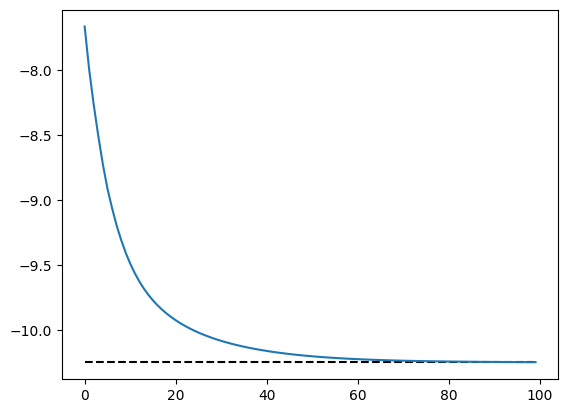

In [9]:
H = qtx.operator.Ising(h=1.0)
E, wf = H.diagonalize()
exact_state = qtx.state.DenseState(wf)

optimizer = qtx.optimizer.ER(state, H)

energy = qtx.utils.DataTracer()
training_rate = 0.02

for i in range(100):
    step = optimizer.get_step()
    state.update(step * training_rate)
    energy.append(optimizer.energy)

energy.plot(baseline=E)
plt.show()

In [10]:
dense = state.todense()
H_psi = H @ dense
energy = dense @ H_psi
Ebar = H_psi - dense * energy

In small systems, you can transform `Variational` to `DenseState` to check its overlap with the exact ground state.

In [11]:
dense = state.todense().normalize()
overlap = abs(dense @ exact_state)
print("Overlap with the exact ground state:", overlap)

Overlap with the exact ground state: 0.9988871399415886


Now we have a nice neural quantum state for solving the Ising model!

## Avoid overflow

In neural quantum state simulations, we often have very large wavefunctions beyond the range of float64. Here is an example.

In [12]:
model = MyModel(in_size=L, width=16)

W1 = model.layer1.weight
W2 = model.layer2.weight

# Manually multiply weights by 100 to cause overflow
model = eqx.tree_at(lambda model: model.layer1.weight, model, W1 * 100)
model = eqx.tree_at(lambda model: model.layer2.weight, model, W2 * 100)

s = qtx.utils.rand_states()
model(s)

Array(inf, dtype=float64)

To avoid this problem, we define two customized data types, `qtx.utils.LogArray` and `qtx.utils.ScaleArray`, to store large values. They are also accepted as network outputs in Quantax. Instead of using dangerous functions like `jnp.exp` that might cause overflow, one can use `qtx.nn.exp_by_scale` to output safe values expressed by `qtx.utils.ScaleArray`.

In [13]:
class NewModel(eqx.Module):
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear

    def __init__(self, in_size: int, width: int):
        keys = qtx.get_subkeys(2)
        layer1 = eqx.nn.Linear(in_size, width, key=keys[0])
        self.layer1 = qtx.nn.apply_he_normal(keys[0], layer1)
        layer2 = eqx.nn.Linear(width, width, key=keys[1])
        self.layer2 = qtx.nn.apply_lecun_normal(keys[1], layer2)

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = self.layer2(x)
        # Dangerous: psi = jnp.sum(jnp.exp(x))
        # Safe:
        psi = qtx.nn.exp_by_scale(x).sum()
        return psi
    

model = NewModel(in_size=L, width=16)
model = eqx.tree_at(lambda model: model.layer1.weight, model, W1 * 100)
model = eqx.tree_at(lambda model: model.layer2.weight, model, W2 * 100)

psi = model(s)
print(psi)

ScaleArray(
  significand=1.0,
  exponent=15694.038701452482
)


Here the output `ScaleArray` is a PyTree with significand $x$ and exponent $\theta$. The true expressed value is $x e^\theta$, which is beyond the range of float64. In most calculations, this quantity can be treated like an ordinary array object, as shown below.

In [14]:
psi = psi.repeat(8).reshape(2, 4)
print("Reshape psi:", psi)

psi = psi.sum(axis=1)
print("Sum psi:", psi)

psi = psi ** (1 / 10000)
print("Power psi:", psi)

psi = jnp.asarray(psi)
print("To jax Array:", psi)

Reshape psi: ScaleArray(
  significand=[[1. 1. 1. 1.]
 [1. 1. 1. 1.]],
  exponent=[[15694.03870145 15694.03870145 15694.03870145 15694.03870145]
 [15694.03870145 15694.03870145 15694.03870145 15694.03870145]]
)
Sum psi: ScaleArray(
  significand=[4. 4.],
  exponent=15694.038701452482
)
Power psi: ScaleArray(
  significand=[1.00013864 1.00013864],
  exponent=1.5694038701452484
)
To jax Array: [4.80444965 4.80444965]


However, JAX doesn't have a full support for [customized arrays](https://docs.jax.dev/en/latest/jep/28661-jax-array-protocol.html), so one should be careful when using these customized arrays. Here we list several possible problems.

1. Manipulations like `jnp.fn(array)` transform customized arrays to `jax.Array`, causing overflow. To avoid it, call `array.fn()`.

2. Computations like `jax_array * customized_array` always call `jax_array.__mul__(customized_array)`, which returns a `jax.Array` that might cause overflow. To avoid it, use `customized_array * jax_array`.

Here are some examples

In [15]:
significand = jnp.array([0.0, 1.0, 2.0, 3.0])
exponent = jnp.array(10000.0)
psi = qtx.utils.ScaleArray(significand, exponent)

print("Wrong sum:", jnp.sum(psi))
print("Correct sum:", psi.sum())

a = jnp.arange(4)
print("Wrong mul:", a * psi)
print("Correct mul:", psi * a)

Wrong sum: nan
Correct sum: ScaleArray(
  significand=6.0,
  exponent=10000.0
)
Wrong mul: [nan inf inf inf]
Correct mul: ScaleArray(
  significand=[0.         0.33333333 1.33333333 3.        ],
  exponent=10001.098612288668
)


The new network with `ScaleArray` outputs also works with Quantax.

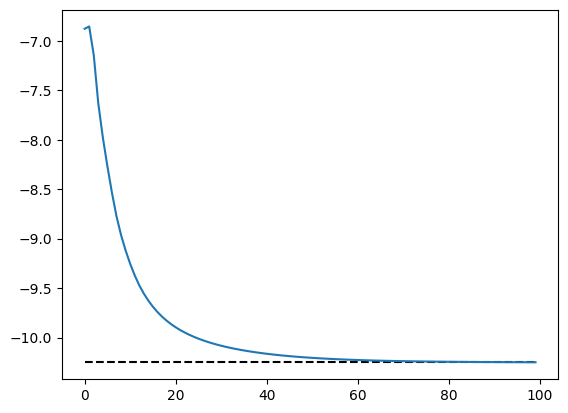

In [21]:
model = NewModel(in_size=L, width=16)
state = qtx.state.Variational(model)
optimizer = qtx.optimizer.ER(state, H)

energy = qtx.utils.DataTracer()
training_rate = 0.02

for i in range(100):
    step = optimizer.get_step()
    state.update(step * training_rate)
    energy.append(optimizer.energy)

energy.plot(baseline=E)
plt.show()